# Project 5 - 02 : Models

In [240]:
%pylab inline
import pandas as pd
import os
import warnings
import joblib
import operator
import matplotlib.colors as mcolors
from random import shuffle
from scipy.sparse import vstack
from sklearn import decomposition
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf
from wordcloud import WordCloud
from skmultilearn.problem_transform import LabelPowerset, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

import nbimporter
from P5_01_EDA import TransformTokenizer  # custom tokenizer from previous notebook


plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

DISPLAY_LDA_VISU = False

Populating the interactive namespace from numpy and matplotlib


D:\Programmes\anaconda3\envs\OC_P5\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['vstack', 'shuffle', 'step', 'clf', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
%load_ext pycodestyle_magic
%flake8_on --max_line_length 140

## Data import

In [3]:
corpus_df = joblib.load("P5_04_data/dataset.pkl")
corpus_voc, bow_vectorizer, tfidf_vectorizer = joblib.load("P5_04_data/fitted-vectorizers.pkl")
try:
    # lda_model_gensim = joblib.load("P5_04_data/lda-gensim.pkl")
    nmf_model_gensim = joblib.load("P5_04_data/nmf-gensim.pkl")
except FileNotFoundError as e:
    print(e)

## Topic Modeling
Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. 

### LDA

#### Baseline

In [22]:
k_topics = 10  # Number of topics to gener. Arbitrary set in a first place

In [5]:
lda_model_sklearn = decomposition.LatentDirichletAllocation(
    n_components=k_topics,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda_model_sklearn.fit(vstack(corpus_df['bow']))

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [6]:
def get_topics_descriptor(model, voc, descriptor_len=10, display=True):
    """ Display the most representative words of the modeled subjects
    args:
        model: sklearn.decomposition model
        feature_names: list(str) - corpus vocabulary
        descr_len: int - Number of terms in the descriptor
        display: bool, optionnal default=True - print the topics descriptors if True
    """
    if display:
        print(f"{descriptor_len} words descriptor of the {k_topics} topics (using {model.__class__.__name__}):\n")
    topic_descr = {}
    for topic_idx, topic in enumerate(model.components_):
        descriptor = [voc[i] for i in topic.argsort()[:-descriptor_len-1:-1]]
        topic_descr[topic_idx+1] = descriptor
        if display:
            print(f"Topic {topic_idx+1:02d}: {', '.join(descriptor)}")

In [7]:
lda_topics_descr = get_topics_descriptor(lda_model_sklearn, corpus_voc, 10, True)

10 words descriptor of the 10 topics (using LatentDirichletAllocation):

Topic 01: user, data, function, value, name, id, request, event, form, code
Topic 02: data, value, column, time, list, self, row, date, number, code
Topic 03: image, color, view, app, text, android, var, child, widget, flutter
Topic 04: int, amp, lt, gt, class, return, type, function, std, code
Topic 05: j, const, import, gt, error, component, app, return, log, function
Topic 06: server, client, service, docker, model, http, connection, name, port, container
Topic 07: gt, lt, div, class, td, id, style, button, item, span
Topic 08: java, com, apache, org, spring, spark, class, jar, springframework, version
Topic 09: quot, name, id, json, type, data, value, label, schema, group
Topic 10: file, error, package, line, version, project, py, user, lib, code


In [8]:
def plot_top_term_weights(voc, weights, topic_idx, top, model_name):
    """ Display a bar plot of the top ranked terms for a given topic
    args:
        voc: list(str) - corpus vocabulary
        weights: ndarray - the term weights relative to each of the k topics
        topic_idx : int - index of the topic
        top: int - Number of terms to display
    """
    # get the top terms and their weights
    top_indices = np.argsort(weights[topic_idx, :])[::-1]
    top_terms = []
    top_weights = []
    for term_idx in top_indices[0:top]:
        top_terms.append(voc[term_idx])
        top_weights.append(weights[topic_idx, term_idx])
    # reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    f, ax = plt.subplots(figsize=(10, 5))
    ypos = np.arange(top)
    ax.barh(ypos, top_weights, align="center", color="#19baff", tick_label=top_terms)
    plt.xlabel("Term Weight", fontsize=14)
    plt.title(f"Top {top} terms in the Topic {topic_idx+1:02d} ({model_name})")
    f.tight_layout()
    plt.show()

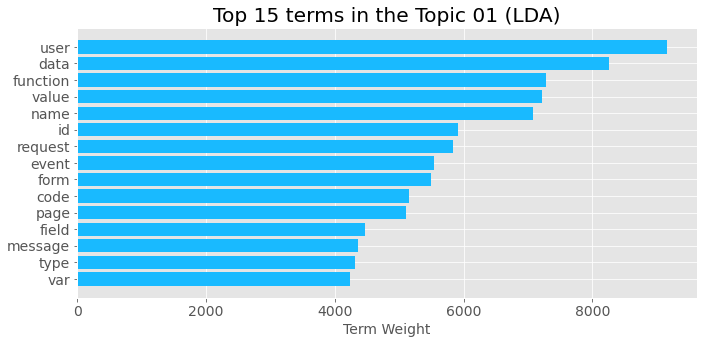

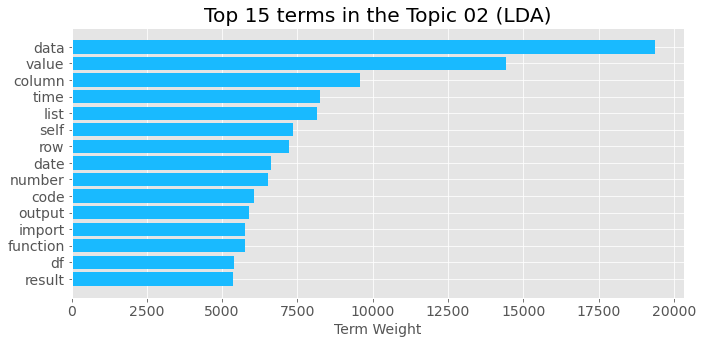

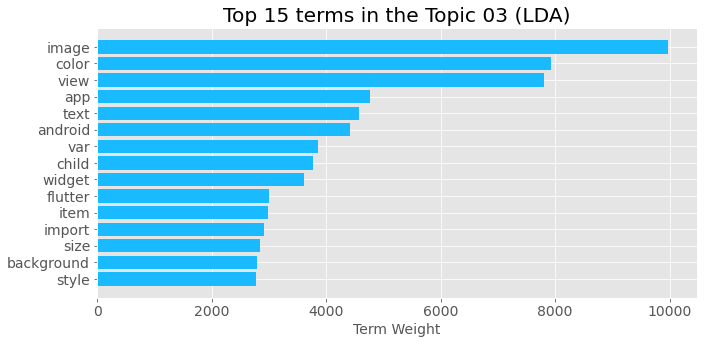

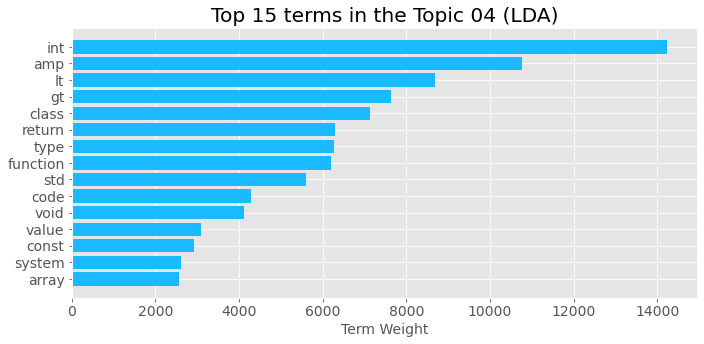

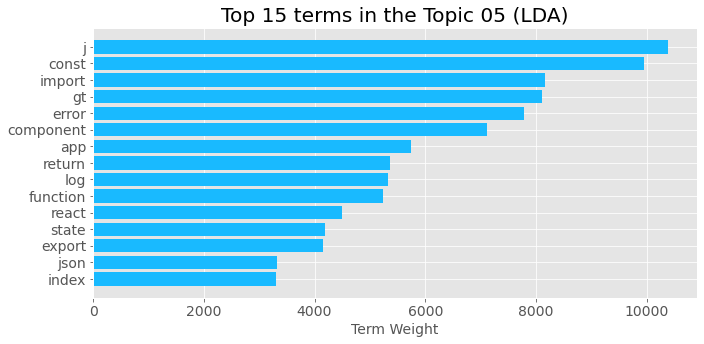

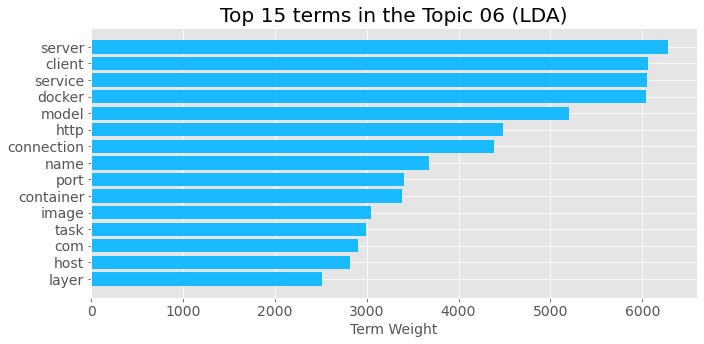

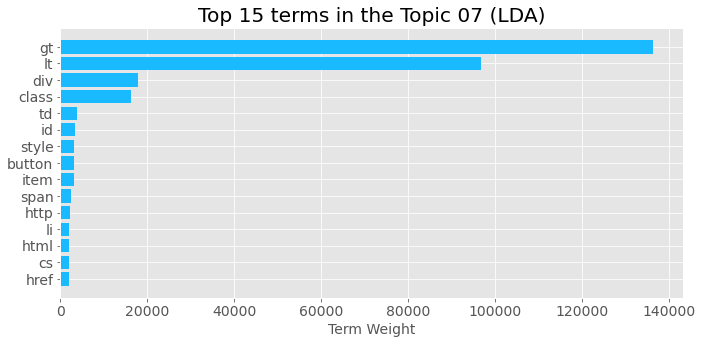

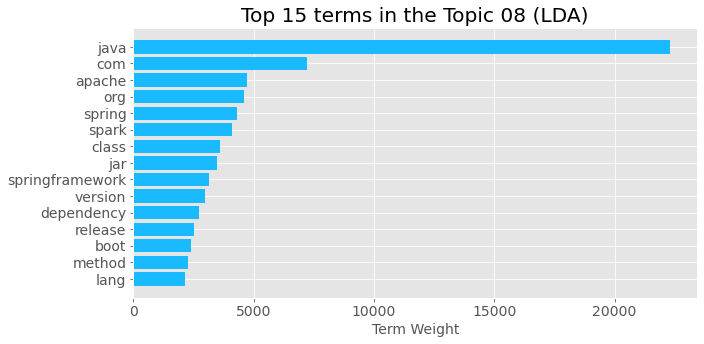

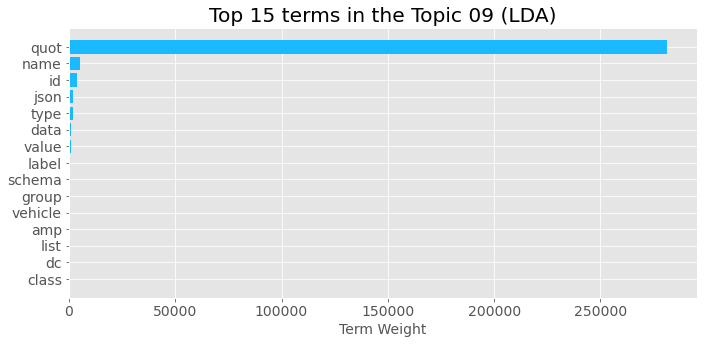

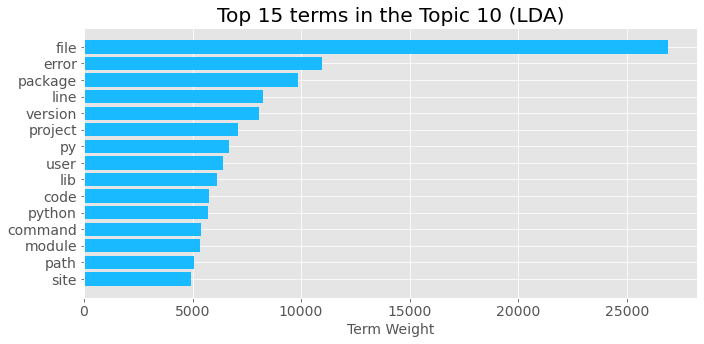

In [9]:
for i in range(k_topics):
    plot_top_term_weights(corpus_voc, lda_model_sklearn.components_, i, 15, 'LDA')

After making the reference model with scikit-learn, I discovered the gensim library, specializing in topic modeling, with a lot of interesting features, especially for the evaluation of models and visualization of detected topics

In [36]:
# compute document-term matrix from gensim
dtm_gensim = Sparse2Corpus(vstack(corpus_df['bow']), documents_columns=False)
# compute tfidf matrix from gensim
tfidf_gensim = Sparse2Corpus(vstack(corpus_df['tfidf']), documents_columns=False)

voc_gensim = Dictionary.from_corpus(dtm_gensim, id2word=dict((id, word) for word, id in bow_vectorizer.vocabulary_.items()))
# saving
joblib.dump((voc_gensim, dtm_gensim, tfidf_gensim), "P5_04_data/voc-dt-tfidf_gensim.pkl")

['P5_04_data/voc-dt-tfidf_gensim.pkl']

In [81]:
lda_params = {
    'corpus': dtm_gensim,
    'id2word': voc_gensim,
    'random_state': 0,
    'chunksize': 100,
    'per_word_topics': True
}

lda_model_gensim = LdaMulticore(num_topics=k_topics, **lda_params)

In [82]:
# Compute Perplexity
print('Perplexity: ', lda_model_gensim.log_perplexity(dtm_gensim))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model_gensim,
    # using inverse_transform() to get the reduced list of tokens
    texts=bow_vectorizer.inverse_transform(vstack(corpus_df['bow'])),
    dictionary=voc_gensim,
    coherence='c_v',
    processes=-1
)
print('Coherence Score: ', coherence_model_lda.get_coherence())

Perplexity:  -6.465081426603736
Coherence Score:  0.6164953949591504


#### Optimal number of topics

In [83]:
def compute_coherence_values(model_type, model_params, tokens, limit, start=2, step=3):
    """Compute c_v coherence for various number of topics
    args:
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics
    Returns:
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    if 'num_topics' in model_params:
        del model_params['num_topics']
    models = {}
    for num_topics in range(start, limit, step):
        print(f"Testing with {num_topics:02d} topics ...", end=' ')
        if model_type == 'lda':
            model = LdaMulticore(num_topics=num_topics, **model_params)
        elif model_type == 'nmf':
            model = Nmf(num_topics=num_topics, **model_params)
        coherencemodel = CoherenceModel(
            model=model,
            texts=tokens,
            dictionary=model_params['id2word'],
            coherence='c_v',
            processes=-1
        )
        models[num_topics] = {'model': model, 'score': coherencemodel.get_coherence()}
        print(f"coherence = {coherencemodel.get_coherence():.3f}")
    return models

In [84]:
%%time

start = 2
limit = 51  # Number of differents tags + 1
step = 4

lda_models = compute_coherence_values(
    model_type='lda',
    model_params=lda_params,
    tokens=bow_vectorizer.inverse_transform(vstack(corpus_df['bow'])),
    start=start, limit=limit, step=step
)

Testing with 02 topics ... coherence = 0.575
Testing with 06 topics ... coherence = 0.559
Testing with 10 topics ... coherence = 0.622
Testing with 14 topics ... coherence = 0.588
Testing with 18 topics ... coherence = 0.583
Testing with 22 topics ... coherence = 0.577
Testing with 26 topics ... coherence = 0.563
Testing with 30 topics ... coherence = 0.572
Testing with 34 topics ... coherence = 0.563
Testing with 38 topics ... coherence = 0.556
Testing with 42 topics ... coherence = 0.550
Testing with 46 topics ... coherence = 0.548
Testing with 50 topics ... coherence = 0.528
Wall time: 14min 24s


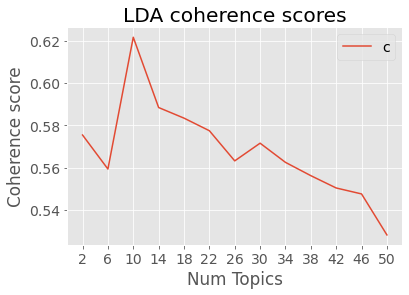

In [86]:
# Show graph
plt.plot(range(start, limit, step), [lda_models[x]['score'] for x in lda_models])
plt.xlabel("Num Topics")
plt.xticks(range(start, limit, 4))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("LDA coherence scores")
plt.show()

In [87]:
best_nbtopics = [x for x in lda_models if lda_models[x]['score'] == max([lda_models[x]['score'] for x in lda_models])][0]
lda_params['num_topics'] = best_nbtopics

In [ ]:
print(f"As we can see, the best coherence score is reached with {best_nbtopics} topics ({lda_models[best_nbtopics]['score']}) for LDA topic modeling")

In [89]:
lda_model_gensim = LdaMulticore(**lda_params)
lda_model_gensim = lda_models[best_nbtopics]['model']
print(f"Coherence Score for {best_nbtopics} topics: {lda_models[best_nbtopics]['score']}")

In [91]:
joblib.dump(lda_model_gensim, "P5_04_data/lda-gensim.pkl")

['P5_04_data/lda-gensim.pkl']

In [92]:
for topic in lda_model_gensim.print_topics(num_topics=best_nbtopics, num_words=10):
    print(f"Topic {topic[0]+1:02d} :\n{topic[1]}\n")

Topic 01 :
0.243*"gt" + 0.176*"lt" + 0.035*"div" + 0.028*"class" + 0.027*"quot" + 0.009*"id" + 0.009*"td" + 0.008*"name" + 0.007*"style" + 0.006*"html"

Topic 02 :
0.025*"data" + 0.020*"value" + 0.016*"time" + 0.013*"quot" + 0.013*"function" + 0.013*"code" + 0.012*"date" + 0.012*"message" + 0.011*"result" + 0.011*"self"

Topic 03 :
0.022*"view" + 0.020*"name" + 0.018*"list" + 0.014*"image" + 0.013*"quot" + 0.012*"child" + 0.011*"data" + 0.011*"text" + 0.011*"class" + 0.011*"color"

Topic 04 :
0.026*"j" + 0.019*"data" + 0.016*"df" + 0.015*"image" + 0.015*"module" + 0.014*"column" + 0.013*"import" + 0.012*"node_modules" + 0.012*"dataframe" + 0.011*"error"

Topic 05 :
0.059*"gt" + 0.039*"quot" + 0.023*"lt" + 0.016*"button" + 0.014*"data" + 0.013*"page" + 0.013*"form" + 0.013*"item" + 0.013*"function" + 0.013*"component"

Topic 06 :
0.024*"model" + 0.022*"quot" + 0.018*"request" + 0.015*"user" + 0.014*"error" + 0.012*"http" + 0.012*"import" + 0.011*"service" + 0.011*"response" + 0.009*"sel

In [93]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [94]:
pyLDAvis.enable_notebook()
lda_visu = gensimvis.prepare(lda_model_gensim, dtm_gensim, voc_gensim)

In [95]:
# This visualization is breaking my jupter notebook so I display it only if needed
if DISPLAY_LDA_VISU:
    lda_visu

In [96]:
pyLDAvis.save_html(lda_visu, f"visualizations-LDA-{lda_params['num_topics']}.html")
pyLDAvis.disable_notebook()

In [97]:
colors_list = [color for name, color in mcolors.XKCD_COLORS.items()]

In [98]:
def display_wordcloud(model, title, plot_format=(2, 3), size=(10, 15), nb_words=10):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=2000,
                      max_words=nb_words,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: colors_list[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(num_topics=model.num_topics, formatted=False)

    fig, axes = plt.subplots(plot_format[0], plot_format[1], figsize=size, sharex=True, sharey=True)
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title(f'Topic {i:02d}', fontdict=dict(size=16))
            plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=10, y=10)
    plt.tight_layout()
    plt.show()

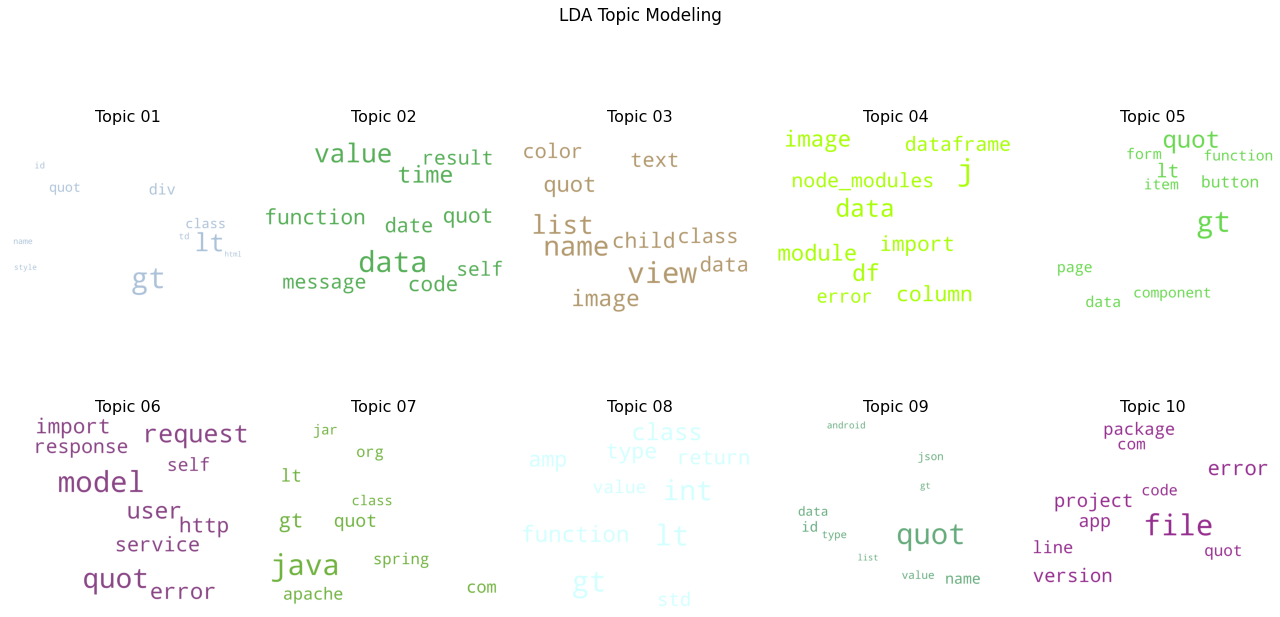

In [99]:
display_wordcloud(lda_model_gensim, title='LDA Topic Modeling', plot_format=(2, 5), size=(18, 10), nb_words=10)

### NMF

NMF produces two factor matrices as its output, **W** and **H** :
- The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.
- The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

#### Baseline
Using the same number of topics as the tuned LDA

In [100]:
# same number of topics as LDA for baseline
nmf_params = {
    'corpus': tfidf_gensim,
    'num_topics': lda_params['num_topics'],
    'id2word': voc_gensim,
    'chunksize': 100,
    'passes': 5,
    'kappa': 1.0,
    'minimum_probability': 0.01,
    'w_max_iter': 200,
    'w_stop_condition': 0.0001,
    'h_max_iter': 50,
    'h_stop_condition': 0.001,
    'eval_every': 10,
    'normalize': True,
    'random_state': 0
}

nmf_model_gensim = Nmf(**nmf_params)

In [101]:
# Compute Coherence Score
coherence_model_nmf = CoherenceModel(
    model=nmf_model_gensim,
    texts=bow_vectorizer.inverse_transform(vstack(corpus_df['tfidf'])),
    dictionary=voc_gensim,
    coherence='c_v',
    processes=-1
)
print('Coherence Score: ', coherence_model_nmf.get_coherence())

Coherence Score:  0.6088240172653805


#### Optimal number of topics

In [102]:
%%time
# searching a better number of topics for NMF modeling
nmf_models = compute_coherence_values(
    model_type='nmf',
    model_params=nmf_params,
    tokens=bow_vectorizer.inverse_transform(vstack(corpus_df['tfidf'])),
    start=start, limit=limit, step=step
)

Testing with 02 topics ... coherence = 0.558
Testing with 06 topics ... coherence = 0.640
Testing with 10 topics ... coherence = 0.609
Testing with 14 topics ... coherence = 0.623
Testing with 18 topics ... coherence = 0.643
Testing with 22 topics ... coherence = 0.618
Testing with 26 topics ... coherence = 0.609
Testing with 30 topics ... coherence = 0.616
Testing with 34 topics ... coherence = 0.600
Testing with 38 topics ... coherence = 0.625
Testing with 42 topics ... coherence = 0.611
Testing with 46 topics ... coherence = 0.603
Testing with 50 topics ... coherence = 0.599
Wall time: 24min


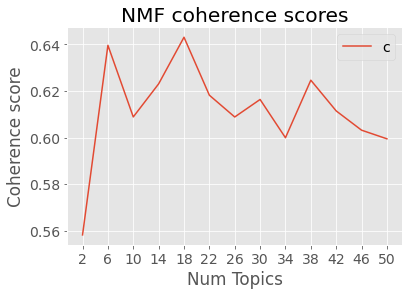

In [103]:
# Show graph
plt.plot(range(start, limit, step), [nmf_models[x]['score'] for x in nmf_models])
plt.xlabel("Num Topics")
plt.xticks(range(start, limit, step))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("NMF coherence scores")
plt.show()

In [104]:
best_nbtopics = [x for x in nmf_models if nmf_models[x]['score'] == max([nmf_models[x]['score'] for x in nmf_models])][0]
nmf_params['num_topics'] = best_nbtopics
print(f"As we can see, the best coherence score is reached with {best_nbtopics} topics for NMF topic modeling")

As we can see, the best coherence score is reached with 18 topics for NMF topic modeling


In [110]:
nmf_model_gensim = nmf_models[best_nbtopics]['model']
print(f"Coherence Score for {best_nbtopics} topics: {nmf_models[best_nbtopics]['score']}")

Coherence Score for 18 topics: 0.6430239554578548


In [106]:
# Saving NMF model
joblib.dump(nmf_model_gensim, "P5_04_data/nmf-gensim.pkl")

['P5_04_data/nmf-gensim.pkl']

In [107]:
for topic in nmf_model_gensim.print_topics(num_topics=best_nbtopics, num_words=10):
    print(f"Topic {topic[0]:02d} :\n{topic[1]}\n")

Topic 01 :
0.102*"file" + 0.017*"line" + 0.014*"path" + 0.013*"folder" + 0.013*"docker" + 0.013*"directory" + 0.010*"git" + 0.010*"command" + 0.008*"package" + 0.007*"csv"

Topic 02 :
0.138*"array" + 0.029*"element" + 0.024*"number" + 0.016*"index" + 0.014*"object" + 0.012*"arr" + 0.011*"length" + 0.010*"integer" + 0.009*"way" + 0.009*"sum"

Topic 03 :
0.127*"model" + 0.024*"layer" + 0.017*"tf" + 0.017*"kera" + 0.014*"loss" + 0.013*"input" + 0.012*"activation" + 0.011*"shape" + 0.009*"django" + 0.009*"field"

Topic 04 :
0.017*"request" + 0.015*"service" + 0.015*"server" + 0.014*"client" + 0.014*"user" + 0.014*"app" + 0.010*"http" + 0.009*"application" + 0.009*"api" + 0.008*"response"

Topic 05 :
0.040*"java" + 0.018*"project" + 0.017*"version" + 0.015*"error" + 0.014*"com" + 0.014*"app" + 0.011*"flutter" + 0.011*"android" + 0.009*"studio" + 0.008*"io"

Topic 06 :
0.064*"int" + 0.042*"std" + 0.032*"amp" + 0.028*"lt" + 0.015*"template" + 0.015*"vector" + 0.014*"cout" + 0.014*"return" + 0

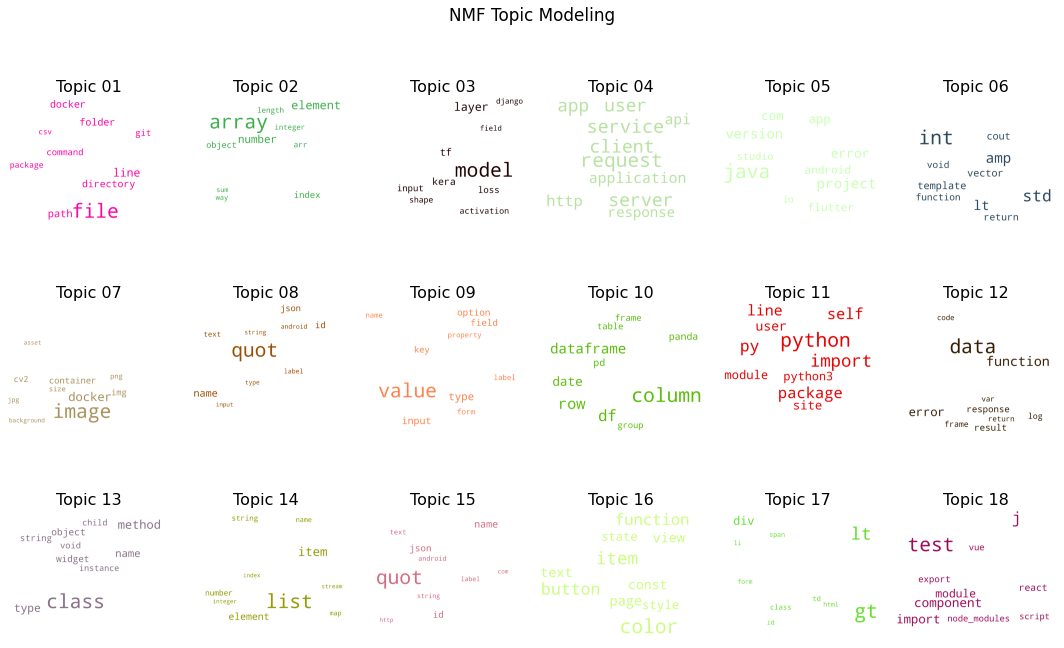

In [111]:
shuffle(colors_list)  # if a topic is hard to read
display_wordcloud(nmf_model_gensim, title='NMF Topic Modeling', plot_format=(3, 6), size=(15, 10), nb_words=10)

**The best coherence score is obtained with NMF topics modeling and 18 topics**

In [112]:
%%time
# assign topics to each doc
corpus_df['topics'] = [nmf_model_gensim.get_document_topics(bow, minimum_probability=None, normalize=None) for bow in dtm_gensim]
# remove probability from the topics
corpus_df['topics'] = corpus_df['topics'].apply(lambda x: [topic[0] for topic in x])

Wall time: 34.8 s


In [113]:
# saving dataset with computed topics
joblib.dump(corpus_df, "P5_04_data/dataset.pkl")

['P5_04_data/dataset.pkl']

In [114]:
mlb_topics = MultiLabelBinarizer()
mlb_topics.fit(corpus_df['topics'])
binary_topics = pd.DataFrame(mlb_topics.transform(corpus_df['topics']), columns=mlb_topics.classes_)

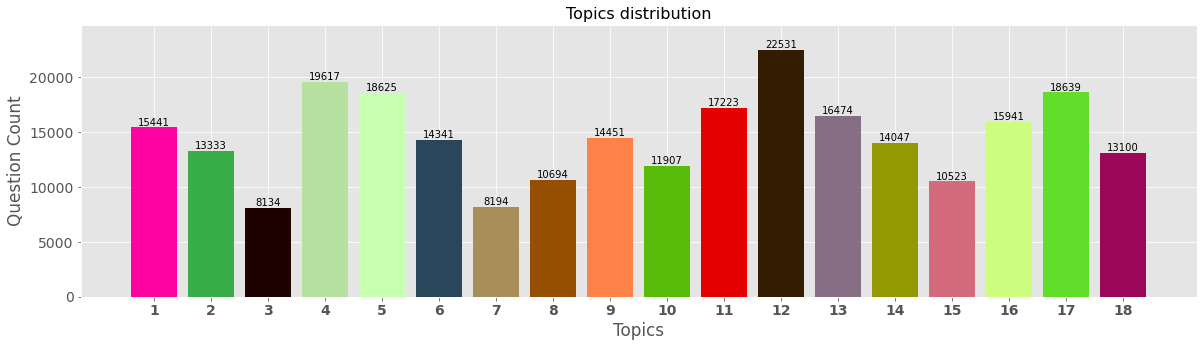

In [115]:
f, ax = plt.subplots(figsize=(20, 5))
values = binary_topics.sum()
plt.bar(x=binary_topics.columns, height=values, color=colors_list)
plt.title('Topics distribution', fontsize=16)
plt.xticks(binary_topics.columns, fontsize=14, fontweight='bold')
plt.xlabel('Topics')
plt.ylabel('Question Count')
# adding the text labels
rects = ax.patches
plt.ylim((0, max(values)+max(values)/10))
for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, val, ha='center', va='bottom', fontsize=10)
plt.show()

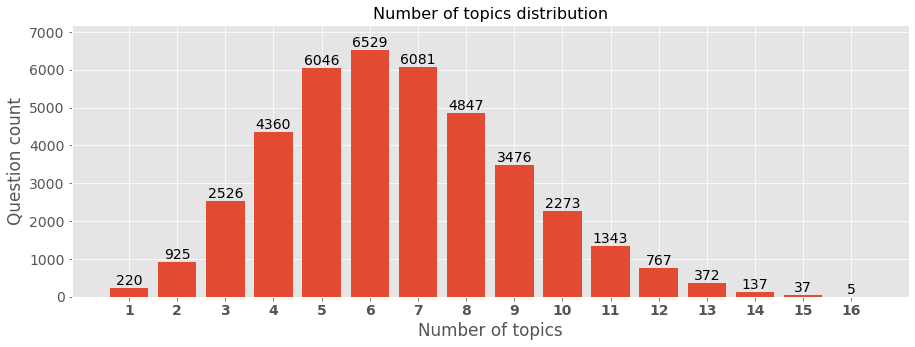

In [116]:
from collections import Counter

nbtopic_distrib = sorted(dict(Counter([len(x) for x in corpus_df['topics']])).items())
nbtopic = [x[0] for x in nbtopic_distrib]
values = [x[1] for x in nbtopic_distrib]

f, ax = plt.subplots(figsize=(15, 5))
plt.bar(x=nbtopic, height=values)
plt.title('Number of topics distribution', fontsize=16)
plt.xticks(nbtopic, fontsize=14, fontweight='bold')
plt.xlabel('Number of topics')
plt.ylabel('Question count')
# adding the text labels
rects = ax.patches

plt.ylim((0, max(values)+max(values)/10))
for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, val, ha='center', va='bottom', fontsize=14)
plt.show()

### topics / tags association

In [129]:
X = corpus_df['doc']

In [191]:
# outputs binarization
mlb_tags = MultiLabelBinarizer()
y = pd.DataFrame(mlb_tags.fit_transform(corpus_df['reduced_tags']), columns=mlb_tags.classes_)

In [192]:
tag_doc_matrix = pd.DataFrame(mlb_tags.fit_transform(corpus_df['reduced_tags']), columns=mlb_tags.classes_).T
print("tag/doc matrix:", tag_doc_matrix.shape)

doc_topic_matrix = binary_topics.copy()
print("doc/topic matrix:", doc_topic_matrix.shape)


tag/doc matrix: (50, 39944)
doc/topic matrix: (39944, 18)


In [197]:
tag_topic_matrix = tag_doc_matrix.dot(doc_topic_matrix)
print("tag/topic matrix:", tag_topic_matrix.shape)

tag/topic matrix: (50, 18)


In [213]:
# doc_tag_matrix = tag_topic_matrix.dot(doc_topic_matrix.T)
# print("doc/tag matrix:", doc_tag_matrix.shape)

In [217]:
tag_topic_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
algorithm,115,511,193,192,211,442,146,86,369,296,344,320,161,452,99,200,291,162
amazon-web-services,419,208,141,658,410,233,155,165,247,210,327,459,255,224,177,213,163,259
android,666,469,264,1373,1985,702,552,592,531,371,700,986,1152,764,640,1086,993,626
angular,334,283,143,602,444,188,100,245,349,161,342,495,442,242,272,463,594,596
apache-spark,220,160,90,208,263,117,48,148,232,405,187,291,135,174,143,88,160,84
arrays,117,583,90,123,131,242,64,165,299,189,177,311,164,278,153,212,295,142
asp.net-core,185,94,94,393,272,116,42,126,130,67,121,211,251,128,148,93,252,112
azure,274,132,88,527,322,170,84,155,168,143,193,321,151,173,131,167,148,137
c,294,376,92,208,261,566,91,175,245,102,351,388,180,195,191,216,307,135
c#,733,609,327,1221,1004,872,217,576,735,362,653,1022,1073,772,521,511,1002,389


In [220]:
mapping_tag_topic = {}
for i, r in tag_topic_matrix.iterrows():
    mapping_tag_topic[i] = r.argmax()

In [235]:
mapping_tag_topic

{'algorithm': 1,
 'amazon-web-services': 3,
 'android': 4,
 'angular': 3,
 'apache-spark': 9,
 'arrays': 1,
 'asp.net-core': 3,
 'azure': 3,
 'c': 5,
 'c#': 3,
 'c++': 5,
 'css': 16,
 'dart': 12,
 'dataframe': 9,
 'django': 2,
 'docker': 0,
 'dplyr': 9,
 'firebase': 3,
 'flutter': 12,
 'git': 0,
 'github': 0,
 'html': 16,
 'ios': 4,
 'java': 4,
 'javascript': 15,
 'jquery': 16,
 'json': 11,
 'kotlin': 4,
 'kubernetes': 3,
 'laravel': 3,
 'node.js': 3,
 'numpy': 1,
 'pandas': 9,
 'php': 11,
 'postgresql': 3,
 'powershell': 0,
 'python': 10,
 'python-3.x': 10,
 'r': 11,
 'react-native': 15,
 'reactjs': 17,
 'spring': 12,
 'spring-boot': 3,
 'sql': 9,
 'swift': 15,
 'swiftui': 15,
 'tensorflow': 2,
 'typescript': 17,
 'visual-studio-code': 0,
 'vue.js': 17}

In [237]:
corpus_df['topics_deducted_tags'] = [
    [list(mapping_tag_topic.keys())[list(mapping_tag_topic.values()).index(t)]
    for t in topics if t in mapping_tag_topic.values()]
    for topics in corpus_df['topics']
]

In [239]:
corpus_df

,doc,tags,tags_cnt,words_cnt,reduced_tags,reduced_tags_cnt,tokens,tokens_cnt,bow,tfidf,topics,topics_deducted_tags
id,,,,,,,,,,,,
65526356,"Pyspark + Graphframes: ""recursive"" message agg...","[python, apache-spark, pyspark, apache-spark-s...",5,253,"[python, apache-spark]",2,"[Pyspark, Graphframes, message, aggregation, g...",75,"(0, 6947)\t1\n (0, 5490)\t3\n (0, 290)\t1\...","(0, 6343)\t0.05978635893648068\n (0, 7811)\...","[3, 8, 10, 12, 14, 15, 16]","[amazon-web-services, python, dart, javascript..."
65526323,Set if conditions based on radio input value ...,"[javascript, jquery]",2,190,"[javascript, jquery]",2,"[Set, condition, radio, input, value, radio, i...",182,"(0, 4214)\t4\n (0, 5832)\t3\n (0, 9398)\t7...","(0, 5383)\t0.04501977251160027\n (0, 1422)\...","[2, 5, 7, 8, 11, 15, 16]","[django, c, json, javascript, css]"
65526301,How do I create new rows based on cell value? ...,"[r, excel]",2,155,[r],1,"[row, cell, value, Days, Treatment, Treatment,...",23,"(0, 9398)\t2\n (0, 2942)\t1\n (0, 7550)\t2...","(0, 5641)\t0.12973788550634488\n (0, 2948)\...","[4, 8, 9, 15]","[android, apache-spark, javascript]"
65526283,How to skip lines when printing output from Pa...,"[python, ssh, paramiko]",3,187,[python],1,"[line, output, Paramiko, SSH, So, program, log...",131,"(0, 5960)\t1\n (0, 7012)\t10\n (0, 5169)\t...","(0, 22)\t0.04527765311112256\n (0, 6370)\t0...","[0, 3, 10, 14]","[docker, amazon-web-services, python]"
65526149,"Pytest: customize short test summary info, rem...","[python, pytest]",2,382,[python],1,"[Pytest, customize, test, info, filepath, outp...",210,"(0, 4214)\t2\n (0, 9398)\t2\n (0, 9618)\t2...","(0, 5980)\t0.03177927935591096\n (0, 5245)\...","[7, 8, 13, 17]",[reactjs]
...,...,...,...,...,...,...,...,...,...,...,...,...
62156108,Should I handle exception with Closable.use{.....,[kotlin],1,120,[kotlin],1,"[exception, use, Kotlin, source, Closable, use...",51,"(0, 2942)\t1\n (0, 3879)\t6\n (0, 9414)\t1...","(0, 1040)\t0.18687656391854177\n (0, 3183)\...","[0, 3, 4, 11, 12, 16, 17]","[docker, amazon-web-services, android, json, d..."
62156073,What is the best way to represent honeycomb la...,"[python, data-structures, logic, mathematical-...",4,144,[python],1,"[way, honeycomb, lattice, lattice, particle, a...",36,"(0, 9618)\t2\n (0, 7550)\t4\n (0, 1492)\t1...","(0, 4978)\t0.19208423710211286\n (0, 606)\t...","[1, 4, 9, 12]","[algorithm, android, apache-spark, dart]"
62156057,How to convert string to double in PowerShell?...,"[powershell, type-conversion]",2,394,[powershell],1,"[string, PowerShell, PowerShell, data, CSV, er...",310,"(0, 4214)\t1\n (0, 5832)\t4\n (0, 9398)\t1...","(0, 5875)\t0.10930309106574534\n (0, 6865)\...","[0, 8, 9, 10, 11, 12, 13, 16, 17]","[docker, apache-spark, python, json, dart, css..."


## Classification

In [ ]:
X = corpus_df['doc']
y = mlb_tags.fit_transform(corpus_df['reduced_tags'])

In [117]:
corpus_df.head(3)

,doc,tags,tags_cnt,words_cnt,reduced_tags,reduced_tags_cnt,tokens,tokens_cnt,bow,tfidf,topics
id,,,,,,,,,,,
65526356,"Pyspark + Graphframes: ""recursive"" message agg...","[python, apache-spark, pyspark, apache-spark-s...",5,253,"[python, apache-spark]",2,"[Pyspark, Graphframes, message, aggregation, g...",75,"(0, 6947)\t1\n (0, 5490)\t3\n (0, 290)\t1\...","(0, 6343)\t0.05978635893648068\n (0, 7811)\...","[3, 8, 10, 12, 14, 15, 16]"
65526323,Set if conditions based on radio input value ...,"[javascript, jquery]",2,190,"[javascript, jquery]",2,"[Set, condition, radio, input, value, radio, i...",182,"(0, 4214)\t4\n (0, 5832)\t3\n (0, 9398)\t7...","(0, 5383)\t0.04501977251160027\n (0, 1422)\...","[2, 5, 7, 8, 11, 15, 16]"
65526301,How do I create new rows based on cell value? ...,"[r, excel]",2,155,[r],1,"[row, cell, value, Days, Treatment, Treatment,...",23,"(0, 9398)\t2\n (0, 2942)\t1\n (0, 7550)\t2...","(0, 5641)\t0.12973788550634488\n (0, 2948)\...","[4, 8, 9, 15]"


In [141]:
%%time
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.33, shuffle=True)

Wall time: 236 ms


In [132]:
# Inputs vectorization
X_train_vect = tfidf_vectorizer.fit_transform(X_train)
X_test_vect = tfidf_vectorizer.transform(X_test)

In [134]:
X_train_vect.shape

(26762, 7278)

### One Vs Rest

Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).
In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.  
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

In [145]:
%%time
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for tag in mlb_tags.classes_:
    print(f"Processing tag {tag!r:{21}}", end=' ')

    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train_vect, y_train[tag])

    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test_vect)
    print(f'-> Testset accuracy = {accuracy_score(y_test[tag], prediction):.3f}')

Processing tag 'algorithm'          -> Testset accuracy = 0.987
Processing tag 'amazon-web-services' -> Testset accuracy = 0.985
Processing tag 'android'            -> Testset accuracy = 0.967
Processing tag 'angular'            -> Testset accuracy = 0.981
Processing tag 'apache-spark'       -> Testset accuracy = 0.993
Processing tag 'arrays'             -> Testset accuracy = 0.985
Processing tag 'asp.net-core'       -> Testset accuracy = 0.990
Processing tag 'azure'              -> Testset accuracy = 0.991
Processing tag 'c'                  -> Testset accuracy = 0.988
Processing tag 'c#'                 -> Testset accuracy = 0.965
Processing tag 'c++'                -> Testset accuracy = 0.974
Processing tag 'css'                -> Testset accuracy = 0.982
Processing tag 'dart'               -> Testset accuracy = 0.981
Processing tag 'dataframe'          -> Testset accuracy = 0.980
Processing tag 'django'             -> Testset accuracy = 0.991
Processing tag 'docker'             -> 

### Classifier Chain

A chain of binary classifiers C_0, C_1, . . . , C_n is constructed, where a classifier C_i uses the predictions of all the classifier C_j , where j < i.   
This way the classifier chains method can take into account label correlations.  
The total number of classifiers needed for this approach is equal to the number of classes, but the training of the classifiers is more involved. 

In [144]:
%%time
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression(max_iter=200, random_state=0))
# Training logistic regression model on train data
classifier.fit(X_train_vect, y_train)
# predict
predictions = classifier.predict(X_test_vect)
# accuracy
print("ClassifierChain testset accuracy =", accuracy_score(y_test, predictions))

ClassifierChain testset accuracy = 0.3616294947655894
Wall time: 12min 44s


In [146]:
joblib.dump(classifier, "P5_04_data/classifier-chain.pkl")

['P5_04_data/classifier-chain.pkl']

In [147]:
%%time
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [RandomForestClassifier(random_state=0)],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 1, 2],
        'classifier__n_estimators': [10, 20, 50],
    },
    {
        'classifier': [LogisticRegression(max_iter=200, random_state=0)],
    },
]

clf = GridSearchCV(ClassifierChain(), parameters, scoring='accuracy')
clf.fit(X_train_vect, y_train)

print(clf.best_params_, clf.best_score_)

{'classifier': RandomForestClassifier(n_estimators=50, random_state=0), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__n_estimators': 50} 0.3467977318503489
Wall time: 7h 29min 53s


In [246]:
predictions = clf.predict(X_test_vect)
print("Tuned ClassifierChain testset accuracy =", accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Tuned ClassifierChain testset accuracy = 0.36496737976027915
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       183
           1       0.83      0.36      0.51       264
           2       0.90      0.61      0.73       786
           3       0.96      0.37      0.53       301
           4       0.89      0.46      0.61       161
           5       1.00      0.00      0.01       208
           6       0.79      0.10      0.18       150
           7       0.85      0.21      0.33       190
           8       0.91      0.20      0.33       194
           9       0.85      0.37      0.52       579
          10       0.96      0.64      0.77       730
          11       0.83      0.29      0.43       372
          12       0.56      0.12      0.19       242
          13       0.50      0.00      0.01       280
          14       0.97      0.56      0.71       221
          15       0.95      0.68      0.79       376
          16       0

D:\Programmes\anaconda3\envs\OC_P5\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programmes\anaconda3\envs\OC_P5\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: multilabel-indicator is not supported

In [149]:
joblib.dump(clf, "P5_04_data/tuned-classifier-chain.pkl")

['P5_04_data/tuned-classifier-chain.pkl']

In [244]:
# clf = joblib.load("P5_04_data/tuned-classifier-chain.pkl")

In [243]:
print(clf.best_params_, clf.best_score_)

AttributeError: 'function' object has no attribute 'best_params_'

### Universal Sentence Encoder tests

In [248]:
import tensorflow_hub as hub

use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = use_model([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.016075   ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.05080861 -0.01652429  0.0157378  ...  0.00976658  0.03170122
   0.01788118]], shape=(2, 512), dtype=float32)


In [ ]:
embeddings = use_model(corpus_df['doc'])